In [2]:
#| output: false

import numpy as np
import matplotlib.pyplot as plt
import modules.functions as fs
import matplotlib.gridspec as gridspec
import scipy.stats
from copy import deepcopy
from vxtools.summarize.structure import SummaryFile
from modules.dataloader import MultiFish, SingleFish
from modules.plotstyle import PlotStyle
from sklearn.metrics import auc
from scipy.stats import pearsonr
from modules.contrast import selective_rois_trash, rg_activity_trash, phase_activity
#%matplotlib qt

ps = PlotStyle()

/home/weygoldt/Data/uni/neuro_gp/calciumimaging/code/modules/functions.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Importing data

In order to work with a datasat including all 3 fish we recorded from, we first load the SummaryFile datasets as well as the beharioral data (if available) from all 3 fish using our `SingleFish` class. The class accepts a list of 'good' recordings that will be loaded. If other recordings are supposed to be loaded, the `overwrite` switch should be set to rewrite the data on disk, which makes loading a class instance faster. Since we work with multiple fish, `SingleFish` instances are combined to one dataset if supplied to our `MultiFish` class. 

In [3]:
#| output: false

# now load the data
data1 = '../data/data1/'
data2 = '../data/data2/'
data3 = '../data/data3/'

f1 = SummaryFile(data1 + 'Summary.hdf5')
f2 = SummaryFile(data2 + 'Summary.hdf5')
f3 = SummaryFile(data3 + 'Summary.hdf5')

good_recs1 = np.arange(3,15)
good_recs2 = [0, 1, 2, 4, 5]
good_recs3 = [0, 1, 2, 3, 4]

# load matrix of all rois of all layers with good rois
d1 = SingleFish(f1, good_recs1, overwrite=False, behav=False)
d2 = SingleFish(f2, good_recs2, overwrite=False, behav=True)
d3 = SingleFish(f3, good_recs3, overwrite=False, behav=False)

# load all fish in multifish class
mf = MultiFish([
    d1, 
    d2, 
    d3
])

To get an overview of the dataset, we plot the zscores for every single ROI in a heatmap.

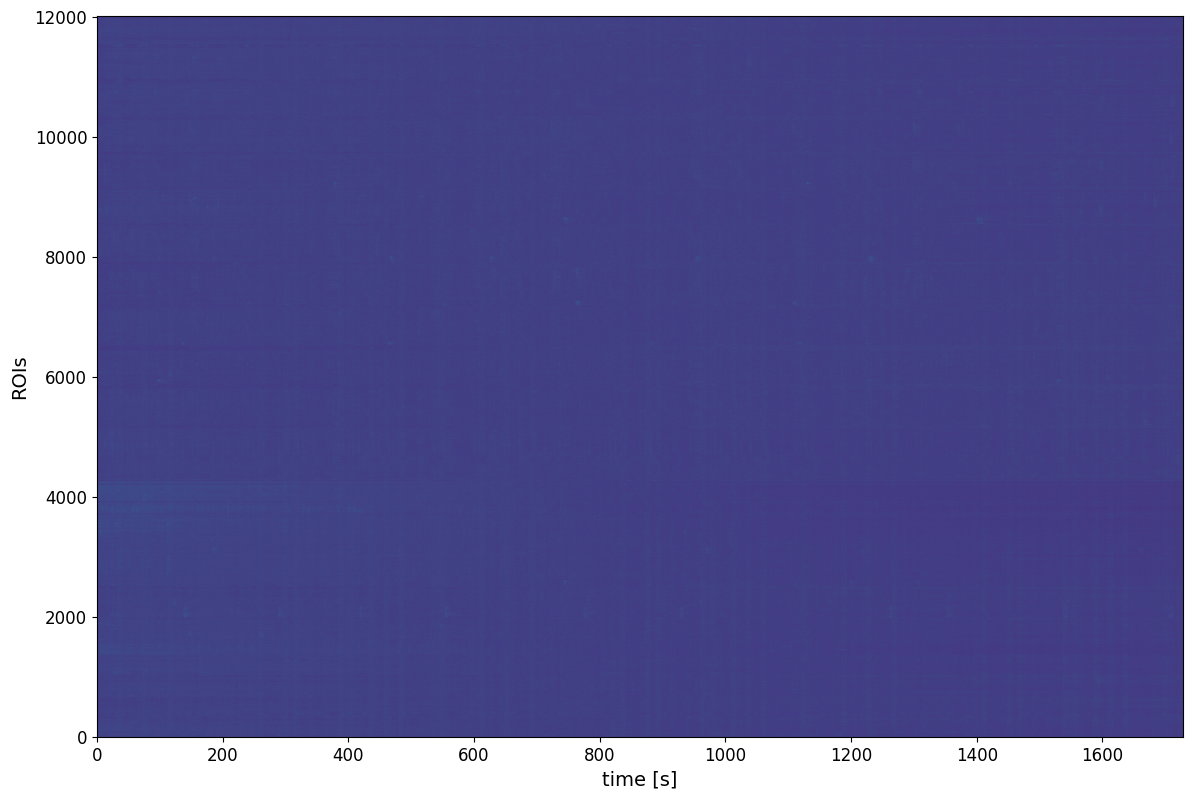

In [4]:
#| code-fold: true

# make imshow extent and flatten data for phases in dff matrix
extent = (mf.times.min(), mf.times.max(), 0, len(mf.zscores[:,0]))
temp_zscores = np.asarray([fs.flatten(x) for x in mf.zscores])

fig, ax = plt.subplots(figsize=(30*ps.cm, 20*ps.cm), constrained_layout=True)
ax.imshow(temp_zscores, extent=extent, aspect="auto")
ax.set_xlabel("time [s]")
ax.set_ylabel("ROIs")
plt.show()

Now we compute the mean zscore and dff for every ROI in every single stimulus phase window.

In [5]:
# compute the mean in each phase
mf.phase_means()


[ MutliFish.phase_means ] Computing means across phases ...


In order to filter out ROIs that responded to stimulation, we compute the autocorrelation of a single ROI across stimulation trial repeats and threshold it using a tail of the probability distribution of the autocorrelation coefficients.

In [6]:
#| output: false

target_auc = 0.2 # probability threshold

# compute the correlations and indices sorted by correlations
indices, corrs = mf.responding_rois(mf.dffs, nrepeats=3)

# make a histpgram
counts, edges = np.histogram(corrs, bins=50, range=(-1,1), density=True)

# compute a gaussian KDE
xkde, kde = fs.kde1d(corrs, 0.02, xlims=[edges.min(), edges.max()])

# create empty arrays for the gradient and index
gradient = np.zeros_like(xkde[:-1])
index = np.arange(len(xkde[:-1]))

# compute the gradient between the target and actual auc
for i in range(len(xkde[:-1])):
    area = auc(xkde[i:], kde[i:])
    gradient[i] = abs(area-target_auc)

# find the index where the gradient is smallest
idx = index[gradient == gradient.min()][0]

# get the threshold for correlation coefficients here
thresh = xkde[idx]
print(f"{thresh=}")

computed AreaUnderCurve (AUC) of KDE using sklearn.metrics.auc: 0.9999695259423385
thresh=0.3627254509018034


The following plot shows the probability density function and marks the area under the curve (AUC) that we use the get the threshold for the correlation coefficients from the value at the threshold on the x axis.

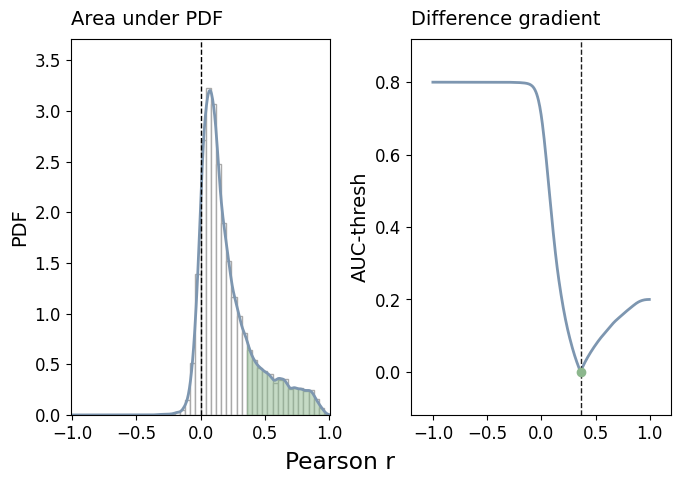

In [9]:
#| code-fold: true

# plot PDF, histogram and the gradient
fig, ax = plt.subplots(1,2,figsize=(17*ps.cm, 12*ps.cm), constrained_layout=True)

ax[0].plot(xkde, kde, c=ps.c1, lw=2)

ax[0].bar(
    edges[:-1], 
    counts, 
    width=np.diff(edges),
    edgecolor="darkgray", 
    facecolor="white", 
    # alpha=0.2,
    linewidth=1, 
    align="edge", 
    zorder=-20
)

ax[0].axvline([0], lw=1, ls="dashed", c="k")

ax[0].fill_between(
    xkde[idx:], 
    np.zeros_like(xkde[idx:]), 
    kde[idx:], 
    zorder=-10, 
    alpha=0.5, 
    color=ps.c2
)
ax[0].set_xlim(-1.01, 1.01)
ax[1].plot(xkde[:-1], gradient, c=ps.c1, lw=2)
ax[1].scatter(xkde[idx], gradient[idx], zorder=10, color=ps.c2)
ax[1].axvline(thresh, lw=1, ls="dashed", c=ps.black)

ax[0].set_title("Area under PDF")
ax[0].set_ylabel("PDF")
ax[1].set_title("Difference gradient")
ax[1].set_ylabel("AUC-thresh")

fig.supxlabel("Pearson r")
fs.doublesave('../poster/figs/pcorrelation')

Now we index all ROIs in the `MultiFish` class instance that had a correlation coefficient larger than our threshold. The function `MultiFisch.filter_rois` takes an index along the first dimenstion (ROIs) of the matrices included in the class and extracts only the ROIs given in the index.

The printout should now reflect the number of ROIs that are still included in the dataset.

In [10]:
#| output: false

# only take the indices where correlation coefficients crossed the thresh
indices_thresh = indices[corrs > thresh]
corrs_thresh = corrs[corrs > thresh]

# create the subset of the dataset for these indices
mf.filter_rois(indices_thresh)

print(f"Old number of ROIs: {len(indices)}")
print(f"Number of indices to threshold: {len(indices_thresh)}")
print(f"Number of ROIs after thresholding: {len(mf.dffs[:,0])}")

Old number of ROIs: 12012
Number of indices to threshold: 2390
Number of ROIs after thresholding: 2390


We can visualize the resulting dataset again in a heatmap.

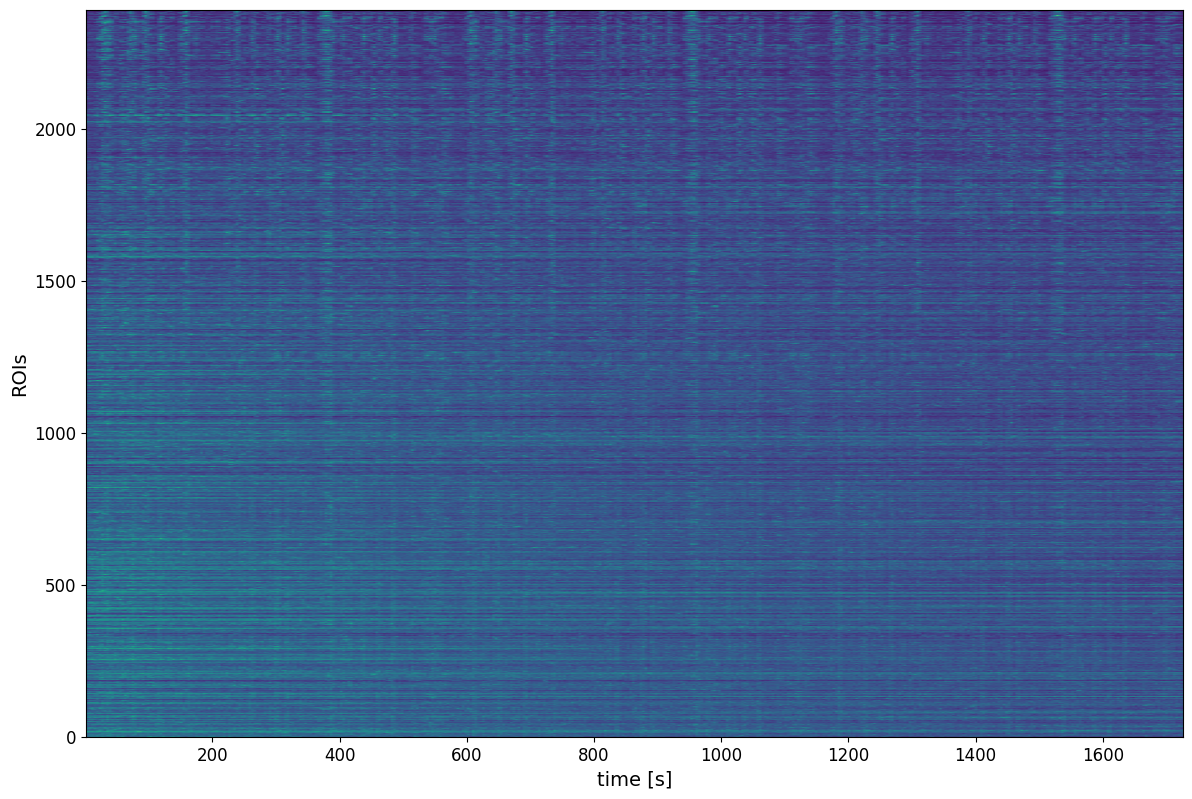

In [11]:
#| code-fold: true

# make imshow extent and flatten data for phases in dff matrix
extent = (mf.times.min(), mf.times.max(), 0, len(mf.dffs[:,0]))

fig, ax = plt.subplots(figsize=(30*ps.cm, 20*ps.cm), constrained_layout=True)
ax.imshow(mf.dffs, extent=extent, aspect="auto")
ax.set_xlabel("time [s]")
ax.set_ylabel("ROIs")
plt.show()

To filter out units that selectivey respond to motion or direction, we build three regressors, one for each category. We quantify the "responsiveness" to these regressors by linear correlation of the dffs with the regressors.

In [12]:
#| output: false

# build motion regressor and correlate
motion = np.array([1 if x != 0 else 0 for x in mf.ang_velocs])
corr_motion = np.array([pearsonr(x, motion)[0] for x in mf.dffs])

# clockwise motion regressor
clock = np.array([1 if x > 0 else 0 for x in mf.ang_velocs])
corr_clock = np.array([pearsonr(x, clock)[0] for x in mf.dffs])

# counterclockwise motion regressor
cclock = np.array([1 if x < 0 else 0 for x in mf.ang_velocs])
corr_cclock = np.array([pearsonr(x, cclock)[0] for x in mf.dffs])

Now we plot the distributions of correlation coefficients with the regressors.

/tmp/ipykernel_15361/3103338192.py:31: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.15, right=1, top=0.92, bottom=0.14, hspace=0)


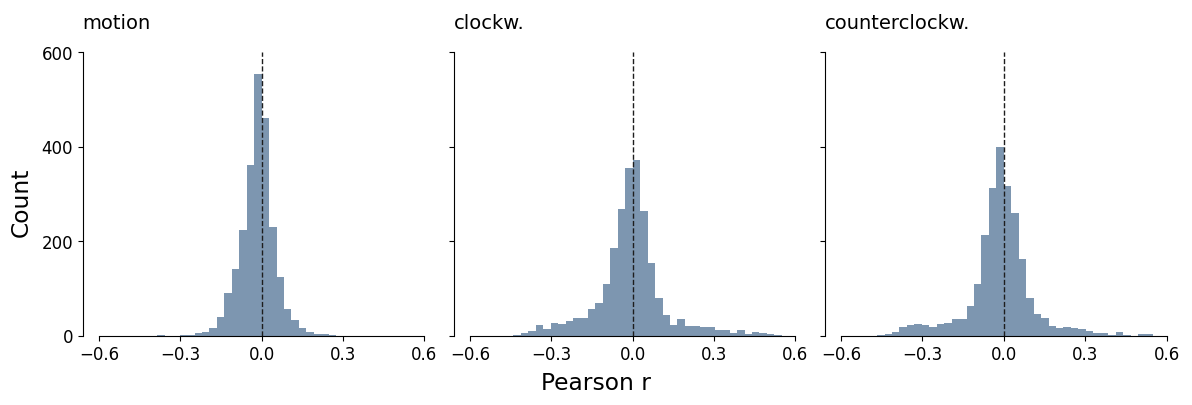

In [13]:
#| code-fold: true

fig, ax = plt.subplots(1,3, figsize=(30*ps.cm, 10*ps.cm), sharex=True, sharey=True, constrained_layout=True)

histr = (-0.55, 0.55)

ax[0].hist(corr_motion, bins=40, range=histr, fc=ps.c1)
ax[0].plot([0,0], [0, 600], lw=1, linestyle='dashed', c=ps.black)

ax[1].hist(corr_clock, bins=40, range=histr, fc=ps.c1)
ax[1].plot([0,0], [0, 600], lw=1, linestyle='dashed', c=ps.black)

ax[2].hist(corr_cclock, bins=40, range=histr, fc=ps.c1)
ax[2].plot([0,0], [0, 600], lw=1, linestyle='dashed', c=ps.black)

ax[0].set_title("motion", y=0.9)
ax[1].set_title("clockw.", y=0.9)
ax[2].set_title("counterclockw.", y=0.9)

# remove upper and right axis
[x.spines["right"].set_visible(False) for x in ax]
[x.spines["top"].set_visible(False) for x in ax]

# make axes nicer
[x.set_yticks(np.arange(0, 601, 200)) for x in ax]
[x.spines.left.set_bounds((0, 600)) for x in ax]

[x.set_xticks(np.arange(-0.6, 0.61, 0.3)) for x in ax]
[x.spines.bottom.set_bounds((-0.6, 0.6)) for x in ax]

plt.subplots_adjust(left=0.15, right=1, top=0.92, bottom=0.14, hspace=0)
fig.supxlabel("Pearson r")
fig.supylabel("Count")

fs.doublesave("../plots/corrcoefs")

plt.show()

Because the distribution does not directly show strong correlations, we use a relatively low threshold of 0.3 to take the right tail of correlation coefficients and get the respective ROIs that where the strongest in terms of correlating with the regressor.

In [14]:
#| output: false

# correlation coefficient threshold
thresh = 0.3

# get index of active ROIs for correlation threshold for clockwise and 
# counterclockwise regressor correlations
index_clock = np.arange(len(mf.dffs[:,0]))[corr_clock > thresh]
index_cclock = np.arange(len(mf.dffs[:,0]))[corr_cclock > thresh]

# create copies of dataset
mfclock = deepcopy(mf)
mfcclock = deepcopy(mf)

# filter direction selective rois
mfclock.filter_rois(index_clock)
mfcclock.filter_rois(index_cclock)

In order to see if our cells respond to increases in achromatic contrast, we collect the zscores for different achromatic contrast levels in the next cell.

In [15]:
#| output: false

# modify motion stim to remove all phases without motion
clock = np.asarray([np.nan if x==0 else x for x in clock])
cclock = np.asarray([np.nan if x==0 else x for x in cclock])

# get achromatic contrast where motion was on
achrom_clock = abs(mf.red-mf.green)*clock
achrom_cclock = abs(mf.red-mf.green)*cclock

# make indices and categories array
index = np.arange(len(achrom_clock))
categories = np.unique(achrom_clock[~np.isnan(achrom_clock)])

# extract activity at different categories
zscores_clock = []
zscores_cclock = []
for c in categories:
    
    # get index for current categories
    idx_clock = index[achrom_clock == c]
    idx_cclock = index[achrom_cclock == c]

    # get zscores at index
    z_clock = mfclock.zscores[:, idx_clock]
    z_cclock = mfcclock.zscores[:, idx_cclock]
    
    # append to lists
    zscores_clock.append(z_clock)    
    zscores_cclock.append(z_cclock)


# make plottable arrays and compute means for both
zscores_clock_mean = np.asarray([np.mean(x) for x in zscores_clock])
zscores_clock_std = np.asarray([np.std(x) for x in zscores_clock])
zscores_cclock_mean = np.asarray([np.mean(x) for x in zscores_cclock])
zscores_cclock_std = np.asarray([np.std(x) for x in zscores_cclock])

# make x axis for scatterplot
zscores_clock_mean_scatterx = fs.flatten(fs.flatten([np.full_like(x, fill_value=y) for x, y in zip(zscores_clock, categories)]))
zscores_cclock_mean_scatterx = fs.flatten(fs.flatten([np.full_like(x, fill_value=y) for x, y in zip(zscores_cclock, categories)]))

# make y axis for scatterplot
zscores_clock_mean_scatter = fs.flatten([fs.flatten(x) for x in zscores_clock])
zscores_cclock_mean_scatter = fs.flatten([fs.flatten(x) for x in zscores_cclock])


Now we plot the results

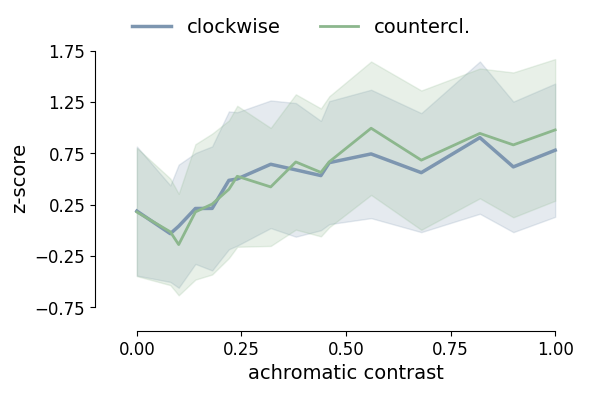

In [17]:
#| code-fold: true

# plot the response to achromatic contrasts
fig, ax = plt.subplots(figsize=(15*ps.cm, 10*ps.cm))

ax.plot(categories, zscores_clock_mean, lw=2.5, c=ps.c1, label="clockwise")
ax.fill_between(categories, zscores_clock_mean-zscores_clock_std, zscores_clock_mean+zscores_clock_std, alpha=0.2, color=ps.c1)

ax.plot(categories, zscores_cclock_mean, lw=2, c=ps.c2, label="countercl.")
ax.fill_between(categories, zscores_cclock_mean-zscores_cclock_std, zscores_cclock_mean+zscores_cclock_std, alpha=0.2, color=ps.c2)

fig.legend(ncols=2, bbox_to_anchor=(0.5, 0.98), loc='upper center')
ax.set_xlabel("achromatic contrast")
ax.set_ylabel("z-score")

# remove upper and right axis
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# make axes nicer
ax.set_yticks(np.arange(-0.75, 2, 0.5))
ax.spines.left.set_bounds((-0.75, 1.75))

ax.set_xticks(np.arange(0, 1.1, 0.25))
ax.spines.bottom.set_bounds((0, 1))

plt.subplots_adjust(left=0.15, right=1, top=0.92, bottom=0.14, hspace=0)
fs.doublesave("../plots/achromatic_curves")

plt.show()

In [18]:
#| output: false

class rg_activity:
    def __init__(self, selective_rois, contr1, contr2):

        self.__rois = selective_rois
        self.__contr1 = contr1
        self.__contr2 = contr2
        self.__index = np.arange(len(self.__contr1))
        self.contr1 = np.unique(self.__contr1[~np.isnan(self.__contr1)])
        self.contr2 = np.unique(self.__contr2[~np.isnan(self.__contr2)])
        self.zscores = []
        # self.mean_dffs = []
        self.contr1_index = []
        self.contr2_index = []
        self.rois = self.__rois.rois
        self.recs = self.__rois.recs
        
        for c1 in self.contr1:

            self.contr1_index.append(c1)
            idx = self.__index[self.__contr1 == c1]
            cat_zscores = self.__rois.zscores[:,idx]
            # mean_dffs = np.mean(cat_dffs, axis=1)
            self.contr2_index.append(self.__contr2[idx])
            self.zscores.append(cat_zscores)
            # self.mean_dffs.append(mean_dffs)

        # self.mean_dffs = np.array(self.mean_dffs)
        self.contr1_index = np.array(self.contr1_index)
        self.contr2_index = np.array(self.contr2_index)

red_clock = clock * mf.red
green_clock = clock * mf.green
red_cclock = cclock * mf.red
green_cclock = cclock * mf.green

rg_clock_data = rg_activity(mfclock, red_clock, green_clock)
rg_cclock_data = rg_activity(mfcclock, red_cclock, green_cclock)
gr_clock_data = rg_activity(mfclock, green_clock, red_clock)
gr_cclock_data = rg_activity(mfcclock, green_cclock, red_cclock)

In [19]:
# output: false

# combine datasets for resampling
bootstr_data_clock = deepcopy(mfclock)
bootstr_data_cclock = deepcopy(mfcclock)

# shuffle zscores
for i in range(len(bootstr_data_clock.zscores[:, 0])):
    clock_index = np.arange(len(mf.ang_velocs))[mf.ang_velocs < 0]
    clock_data = bootstr_data_clock.zscores[i, clock_index]
    np.random.shuffle(clock_data)
    bootstr_data_clock.zscores[i, clock_index] = clock_data

for i in range(len(bootstr_data_cclock.zscores[:, 0])):
    cclock_index = np.arange(len(mf.ang_velocs))[mf.ang_velocs > 0]
    cclock_data = bootstr_data_cclock.zscores[i, cclock_index]
    print(cclock_data[:10])
    np.random.shuffle(cclock_data)
    print(cclock_data[:10])
    print('')
    bootstr_data_cclock.zscores[i, cclock_index] = cclock_data

rg_bootstr_clock = rg_activity(bootstr_data_clock, red_clock, green_clock)
rg_bootstr_cclock = rg_activity(bootstr_data_cclock, red_cclock, green_cclock)
gr_bootstr_clock = rg_activity(bootstr_data_clock, red_clock, green_clock)
gr_bootstr_cclock = rg_activity(bootstr_data_cclock, red_cclock, green_cclock)

[-0.44993188 -0.26208807 -0.50692182 -0.34335453 -0.56053337 -0.53366453
 -0.53594805 -0.45391561 -0.25869281 -0.47209273]
[-0.51049944 -0.39735833 -0.64220562 -0.5213713  -0.60527561 -0.6229452
 -0.64693971 -0.58776846 -0.54380392 -0.29424202]

[-0.12904313 -0.35549226 -0.26972707 -0.3238098  -0.50699138 -0.2702375
 -0.37413594 -0.34782983 -0.18965997 -0.33222261]
[-0.50417396 -0.34782983 -0.50699138 -0.63374296 -0.51646042 -0.50115265
 -0.53846013 -0.50361543 -0.50033657 -0.39824268]

[-0.41594233 -0.52265959 -0.72475885 -0.24737151 -0.64911947 -0.39160755
 -0.64820105 -0.27094097 -0.44177869 -0.29193894]
[-0.50480338 -0.25281523 -0.51048714 -0.68822343 -0.49410954 -0.55557142
 -0.26176425 -0.65790218 -0.48705906 -0.5997957 ]

[-0.08307281 -0.26702293  0.033202   -0.15959231 -0.18622823  0.0625101
 -0.23176895 -0.11152934 -0.3739175  -0.29349679]
[-0.41844036 -0.46766943 -0.63493124  0.11162166 -0.6394633   0.0625101
 -0.34020589 -0.28810094 -0.52354542 -0.17004885]

[-0.46658655 -0.

In [ ]:
cclock_data

In [20]:
# output: false

def dataconverter(data, nresamples=10000, subsetsize=0.95):

    contrast1 = []
    contrast2 = []
    mean_zscores = []
    std_zscores = []
    lower_zscores = []
    upper_zscores = []

    # iterate through contrast levels
    for it1, c1 in enumerate(data.contr1):
        
        # collect zscore and contrast data here
        zscores = []
        contrasts2 = []

        # for each contrast1 level, go through all contrast2 levels
        for zsc in np.array(data.zscores)[data.contr1 == c1]:

            # go through each single ROI and append contrast levels and zscores    
            for  roi in range(len(zsc[:,0])):
            
                # get the contrast2 for this specific contrast1
                contr2 = np.array(data.contr2_index)[data.contr1 == c1][0]

                # sort by contrast level
                sort_zsc = zsc[roi, np.argsort(contr2)]
                sort_contr2 = contr2[np.argsort(contr2)]

                # append contrasts and zscore matrices
                contrasts2.append(sort_contr2)
                zscores.append(sort_zsc)

            # for each contrast 2 category go through and compute the means and std
            lower_zsc = []
            upper_zsc = []
            mean_zsc = []

            contrasts2 = np.asarray(np.ravel(contrasts2))
            zscores = np.asarray(np.ravel(zscores))
            contr2_lvls = np.unique(contrasts2)
        
            for c2 in contr2_lvls:
                
                # compute mean and standard deviation for every c2 contrast level
                # mean_zsc.append(np.mean(zscores[contrasts2 == c2]))
                # std_zsc.append(np.std(zscores[contrasts2 == c2]))
                
                # get zscores for this condition
                zscs = zscores[contrasts2 == c2]
                
                # resample them
                sss = int(np.round(len(zscs)*subsetsize))
                
                # compute mean and std
                m = np.mean(np.ravel(zscs))
                mean_zsc.append(m)
                # lower_zsc.append(lower)
                # upper_zsc.append(upper)

        mean_zsc = np.asarray(mean_zsc)
        # lower_zsc = np.asarray(lower_zsc)
        # upper_zsc = np.asarray(upper_zsc)

        contrast1.append(c1)
        contrast2.append(contr2_lvls)
        mean_zscores.append(mean_zsc)
        # lower_zscores.append(lower_zsc)
        # upper_zscores.append(upper_zsc)
# 
    contrast1 = np.asarray(contrast1)
    contrast2 = np.asarray(contrast2)
    mean_zscores = np.asarray(mean_zscores)
    # lower_zscores = np.asarray(lower_zscores)
    # upper_zscores = np.asarray(upper_zscores)
# 
    return contrast1, contrast2, mean_zscores

contrast1, contrast2, mean_zscores = dataconverter(rg_clock_data)

print(np.shape(mean_zscores))
#print(np.shape(std_zscores))
print(np.shape(contrast1))
print(np.shape(contrast2))

(6, 6)
(6,)
(6, 6)


NameError: name 'lower_zscores' is not defined

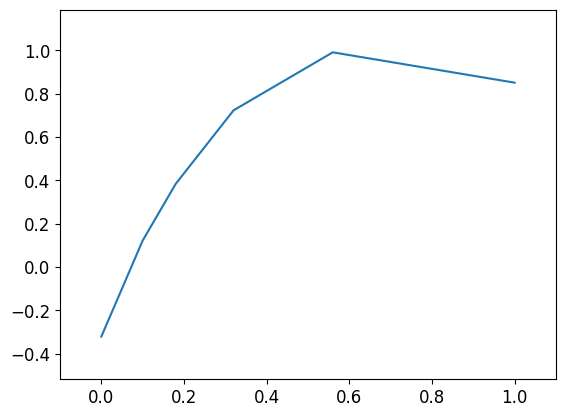

In [21]:
for i in range(len(contrast2[:,0])):
    plt.plot(contrast2[i,:], mean_zscores[i,:])
    plt.fill_between(contrast2[i,:], lower_zscores[i,:], upper_zscores[i,:], alpha = 0.5)
    

Warnign, the bootstrapping done here is still old and wrong!

/tmp/ipykernel_15361/3701600296.py:15: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  stim_axs1[0].get_shared_x_axes().join(stim_axs1[0], *stim_axs1)
/tmp/ipykernel_15361/3701600296.py:16: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  stim_axs1[0].get_shared_y_axes().join(stim_axs1[0], *stim_axs1)
/tmp/ipykernel_15361/3701600296.py:17: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  stim_axs2[0].get_shared_x_axes().join(stim_axs2[0], *stim_axs2)
/tmp/ipykernel_15361/3701600296.py:18: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  stim_axs2[0].get_shared_y_axes().join(stim_axs2[0], *stim_axs2)
/tmp/ipykernel_15361/3701600296.py:99: MatplotlibDeprecationWarning: The

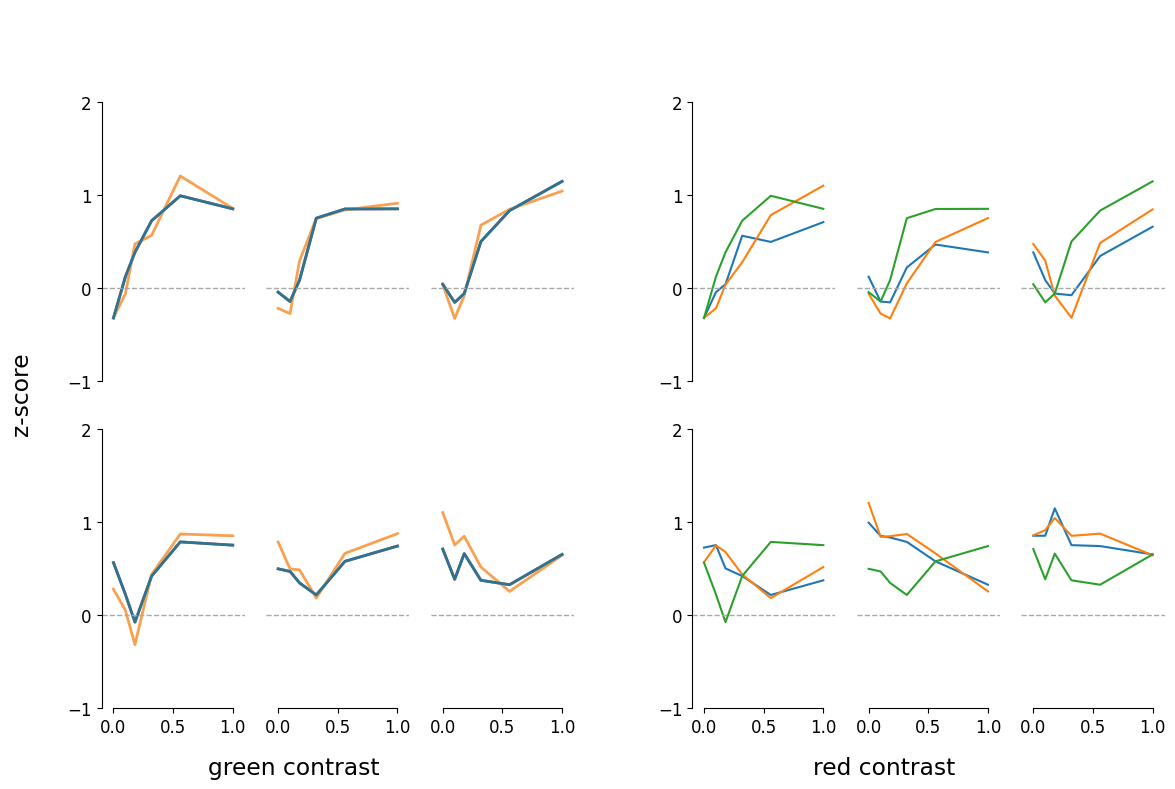

In [22]:
#| code-fold: true

fig = plt.figure(figsize=(30*ps.cm, 20*ps.cm))

# build the subfigures
(subfig_l, subfig_r) = fig.subfigures(1, 2, hspace=0.05, width_ratios=[1, 1])

gs0 = gridspec.GridSpec(2, 3, figure=subfig_l)
stim_axs1 = [subfig_l.add_subplot(i) for i in gs0]

gs1 = gridspec.GridSpec(2, 3, figure=subfig_r)
stim_axs2 = [subfig_r.add_subplot(i) for i in gs1]

# make axes shared
stim_axs1[0].get_shared_x_axes().join(stim_axs1[0], *stim_axs1)
stim_axs1[0].get_shared_y_axes().join(stim_axs1[0], *stim_axs1)
stim_axs2[0].get_shared_x_axes().join(stim_axs2[0], *stim_axs2)
stim_axs2[0].get_shared_y_axes().join(stim_axs2[0], *stim_axs2)

# plot the left side of the plot
colors = [ps.orange, ps.red, ps.blue]
labels = ['clockw.-selective', 'countercl.-selective', 'bootstrap']

# get the data
contrast1, contrast2, mean_zscores_c, = dataconverter(rg_clock_data)
_, _, mean_zscores_cc, = dataconverter(rg_cclock_data)
_, _, mean_zscores_b, = dataconverter(rg_bootstr_clock)

for i, ax in enumerate(stim_axs1):
    
    ax.plot(contrast2[i], mean_zscores_c[i], lw=2, c=ps.red)
    ax.plot(contrast2[i], mean_zscores_cc[i], lw=2, c=ps.orange)
    ax.plot(contrast2[i], mean_zscores_b[i], lw=2, c=ps.blue)

    # ax.fill_between(contrast2[i], lower_c[i], upper_c[i], alpha = 0.2, color=ps.red)
    # ax.fill_between(contrast2[i], lower_cc[i], upper_cc[i], alpha = 0.2, color=ps.orange)
    # ax.fill_between(contrast2[i], lower_b[i], upper_b[i], alpha = 0.2, color=ps.blue)
    
    ax.axhline(0, lw=1, ls='dashed', c='darkgray')

# plot the right side of the plot
colors = [ps.orange, ps.red, ps.blue]
labels = ['clockw.-selective', 'countercl.-selective', 'bootstrap']

# get the data
contrast1, contrast2, mean_zscores_c, = dataconverter(gr_clock_data)
_, _, mean_zscores_cc,  = dataconverter(gr_cclock_data)
_, _, mean_zscores_b,  = dataconverter(gr_bootstr_clock)

for i, ax in enumerate(stim_axs2):
    
    ax.plot(contrast2[i], mean_zscores_c[i])
    ax.plot(contrast2[i], mean_zscores_cc[i])
    ax.plot(contrast2[i], mean_zscores_b[i])

    # ax.fill_between(contrast2[i], lower_c[i], upper_c[i], alpha = 0.2)
    # ax.fill_between(contrast2[i], lower_cc[i], upper_cc[i], alpha = 0.2)
    # ax.fill_between(contrast2[i], lower_b[i], upper_b[i], alpha = 0.2)
    
    ax.axhline(0, lw=1, ls='dashed', c='darkgray')

# remove axes on right and top of plots
[x.spines["right"].set_visible(False) for x in np.asarray(stim_axs1)]
[x.spines["top"].set_visible(False) for x in np.asarray(stim_axs1)]
[x.spines["right"].set_visible(False) for x in np.asarray(stim_axs2)]
[x.spines["top"].set_visible(False) for x in np.asarray(stim_axs2)]

# turn y axes off where not needed
yaxes_off = [1,2,4,5]
[x.get_yaxis().set_visible(False) for x in np.asarray(stim_axs1)[yaxes_off]]
[x.get_yaxis().set_visible(False) for x in np.asarray(stim_axs2)[yaxes_off]]
[x.spines["left"].set_visible(False) for x in np.asarray(stim_axs1)[yaxes_off]]
[x.spines["left"].set_visible(False) for x in np.asarray(stim_axs2)[yaxes_off]]

# turn x axes off where they are not needed
xaxes_off = [0,1,2]
[x.get_xaxis().set_visible(False) for x in np.asarray(stim_axs1)[xaxes_off]]
[x.get_xaxis().set_visible(False) for x in np.asarray(stim_axs2)[xaxes_off]]
[x.spines["bottom"].set_visible(False) for x in np.asarray(stim_axs1)[xaxes_off]]
[x.spines["bottom"].set_visible(False) for x in np.asarray(stim_axs2)[xaxes_off]]

# set all axes to same tick ranges
x_range = np.arange(0,1.5,0.5)
y_range = np.arange(-1,2.1,1)
[x.set_yticks(y_range) for x in np.asarray(stim_axs1)]
[x.set_xticks(x_range) for x in np.asarray(stim_axs1)]
[x.set_yticks(y_range) for x in np.asarray(stim_axs2)]
[x.set_xticks(x_range) for x in np.asarray(stim_axs2)]

# set bounds to make axes nicer
x_bounds = (0,1)
y_bounds = (-1,2)
[x.spines.left.set_bounds(y_bounds) for x in np.asarray(stim_axs1)]
[x.spines.bottom.set_bounds(x_bounds) for x in np.asarray(stim_axs1)]
[x.spines.left.set_bounds(y_bounds) for x in np.asarray(stim_axs2)]
[x.spines.bottom.set_bounds(x_bounds) for x in np.asarray(stim_axs2)]

# make axes shared
stim_axs1[0].get_shared_x_axes().join(stim_axs1[0], *stim_axs1)
stim_axs1[0].get_shared_y_axes().join(stim_axs1[0], *stim_axs1)
stim_axs2[0].get_shared_x_axes().join(stim_axs2[0], *stim_axs2)
stim_axs2[0].get_shared_y_axes().join(stim_axs2[0], *stim_axs2)

# add labels
subfig_l.supylabel('z-score')
subfig_l.supxlabel('green contrast')
subfig_r.supxlabel('red contrast')

# get legend handles
handles1, labels1 = stim_axs1[i].get_legend_handles_labels()
handles2, labels2 = stim_axs2[i].get_legend_handles_labels()

# add legends
subfig_l.legend(handles1, labels1, loc='upper center', ncol=2)
subfig_r.legend(handles2, labels2, loc='upper center', ncol=2)

# adjust margins
plt.subplots_adjust(left=0.175, right=0.975, top=0.87, bottom=0.1, hspace=0.17, wspace=0.15)
fs.doublesave("../plots/contrast_curves")

plt.show()

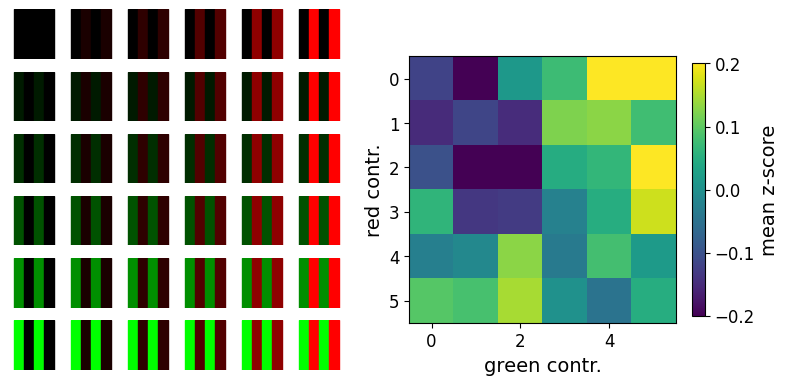

In [23]:
# build the stimulus
reds = np.round(np.geomspace(0.1, 1, 5), 2)
reds = np.append(0, reds)
greens = np.round(np.geomspace(0.1, 1, 5), 2)
greens = np.append(0, greens)
r_rgb = [np.array([r, 0, 0]) for r in reds]
g_rgb = [np.array([0, g, 0]) for g in greens]
rgb_matrix = np.zeros((len(r_rgb), len(g_rgb)), dtype=((float, 3), 2))

for i1 in range(len(rgb_matrix[:, 0])):
    g = g_rgb[i1]

    for i2 in range(len(rgb_matrix[0, :])):
        r = r_rgb[i2]
        rg_rgb = [g, r]
        rgb_matrix[i1, i2] = rg_rgb

dim = np.shape(rgb_matrix)
rgb_matrix_flat = rgb_matrix.reshape(dim[0]*dim[1], dim[2], dim[3])
fill_r = [[0, 2], [1, 3]]
fill_g = [[1, 3], [2, 4]]

# gridspec inside gridspec
fig = plt.figure(figsize=(20*ps.cm, 10*ps.cm))
gs0 = gridspec.GridSpec(1, 2, figure=fig)

# axes for stimulus
gs00 = gs0[0].subgridspec(6, 6)
stim_axs = [fig.add_subplot(i) for i in gs00]

# axis for heatmap
gs01 = gs0[1].subgridspec(1, 1)
heatm_ax = fig.add_subplot(gs01[0])

# plot the stimulus
for axis, rgbs in zip(np.array(stim_axs).flat, rgb_matrix_flat):
    for i in range(len(fill_r)):
        axis.axvspan(fill_r[0][i], fill_r[1][i], color=rgbs[0])
        axis.axvspan(fill_g[0][i], fill_g[1][i], color=rgbs[1])
        axis.axis('off')

# plot the heatmap
# >>> DISCLAIMER this cell can probably be made much nicer but its half past 10 on a saturday

def unique_combinations2d(list1, list2):
    """Combine elments of two lists uniquely."""
    return [(x, y) for x in list1 for y in list2]

reds = np.unique(mf.red)
greens = np.unique(mf.green)
combs = unique_combinations2d(reds, greens)
index = np.arange(len(mf.red))
matrix = np.full((6,6), np.nan)

signal1 = []
signal2 = []
for comb in combs:
    
    loc = index[(mf.red==comb[0]) & (mf.green==comb[1])]
    
    signal1.append(mfclock.zscores[:,loc])
    signal2.append(mfcclock.zscores[:,loc])

signal1 = np.mean(np.mean(signal1, axis=1), axis=1)
signal2 = np.mean(np.mean(signal2, axis=1), axis=1)
signal = np.mean(np.array([signal1, signal2]), axis=0)

# put into matrix
for i,s in enumerate(signal):
    idx = np.unravel_index(i, np.shape(matrix))
    matrix[idx] = s

hm = heatm_ax.imshow(matrix, interpolation="none", vmin=-0.2, vmax=0.2)
heatm_ax.set_xlabel('green contr.')
heatm_ax.set_ylabel('red contr.')

cbar = fig.colorbar(hm, ax=heatm_ax, shrink=0.7)
cbar.ax.set_ylabel('mean z-score')
plt.subplots_adjust(left=0.015, right=0.945, top=0.960, bottom=0.045, hspace=0.250, wspace=0.200)

plt.show()
